Filtering For Single Test Image

Despeckling Performance Metrics:
                            PSNR      SSIM         MSE
median_filter          10.287293  0.082952  100.084656
wiener_filter          10.067811  0.054375  101.262115
wavelet_filter         11.292631  0.168338   95.837112
anisotropic_diffusion  10.915103  0.150872   94.136597
lee_filter             10.748371  0.090950   99.552444
frost_filter           10.809057  0.090840   98.944260
nlm_filter              9.851468  0.043436  102.576981


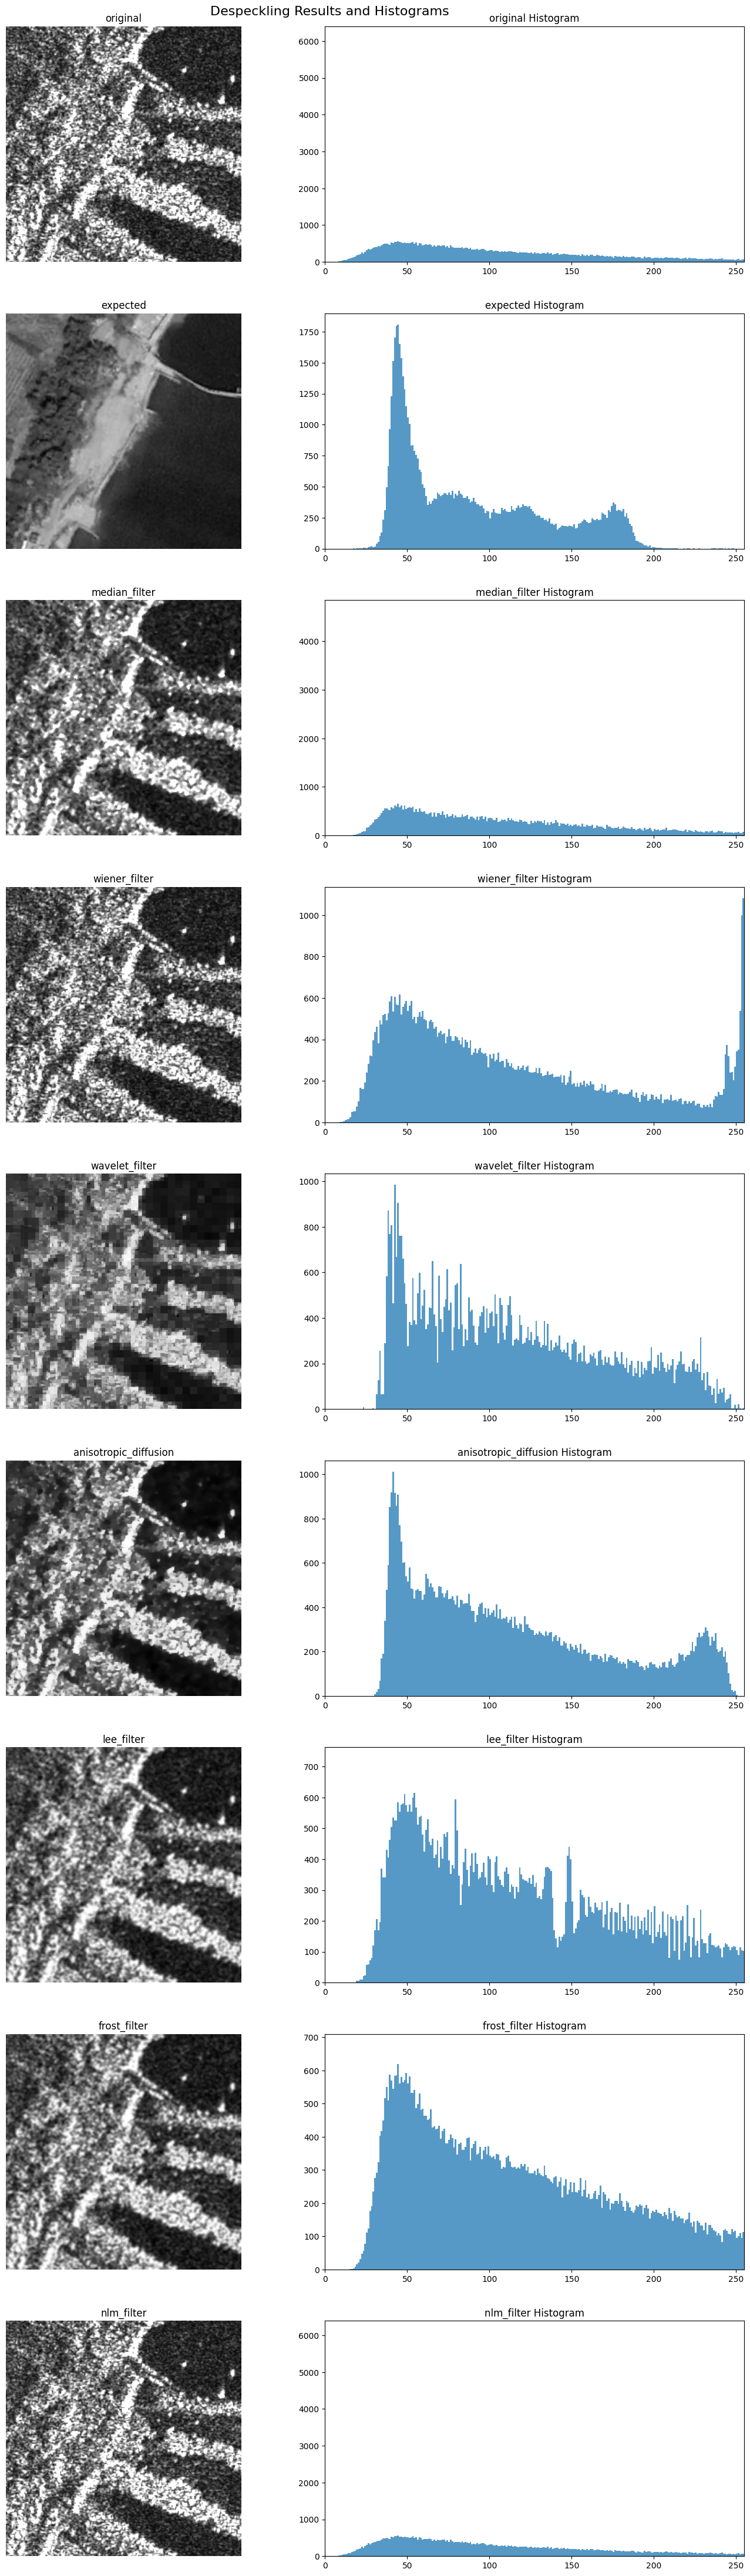

In [1]:
import cv2
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.restoration import denoise_wavelet, denoise_tv_chambolle, denoise_nl_means
from scipy.ndimage import median_filter
from skimage.io import imsave
import pandas as pd

# Suppress warnings for low contrast and other expected issues
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Define paths
input_image_path = "test/sar_tif/907.tif"  # Update this path if necessary
expected_image_path = "test/gray_tif/907.tif"  # Update this path if necessary
output_directory = "output_images"
os.makedirs(output_directory, exist_ok=True)

# Verify paths
if not os.path.exists(input_image_path):
    print(f"Input image not found at {input_image_path}")
elif not os.path.exists(expected_image_path):
    print(f"Expected output image not found at {expected_image_path}")
else:
    # Load images
    input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
    expected_image = cv2.imread(expected_image_path, cv2.IMREAD_GRAYSCALE)

    # Step 1: Bit-plane slicing
    for i in range(8):
        bit_plane = (input_image & (1 << i)) >> i
        bit_plane = (bit_plane * 255).astype(np.uint8)
        bit_plane_path = os.path.join(output_directory, f"bit_plane_{i}.png")
        imsave(bit_plane_path, bit_plane)

    # Step 2: Define despeckling filters
    results = {"original": input_image, "expected": expected_image}

    # Median Filtering
    median_filtered = median_filter(input_image, size=3)
    results["median_filter"] = median_filtered

    # Wiener Filtering (approximated with wavelet denoising)
    wiener_filtered = denoise_wavelet(input_image, method='BayesShrink', mode='soft', wavelet_levels=3, wavelet='haar', rescale_sigma=True)
    wiener_filtered = (wiener_filtered * 255).astype(np.uint8)
    results["wiener_filter"] = wiener_filtered

    # Wavelet Thresholding
    wavelet_filtered = denoise_wavelet(input_image, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='haar', rescale_sigma=True)
    wavelet_filtered = (wavelet_filtered * 255).astype(np.uint8)
    results["wavelet_filter"] = wavelet_filtered

    # Anisotropic Diffusion
    anisotropic_filtered = denoise_tv_chambolle(input_image, weight=0.1)
    anisotropic_filtered = (anisotropic_filtered * 255).astype(np.uint8)
    results["anisotropic_diffusion"] = anisotropic_filtered

    # Lee Filter
    def lee_filter(img, size=3):
        mean = cv2.blur(img, (size, size))
        mean_sq = cv2.blur(img ** 2, (size, size))
        variance = mean_sq - mean ** 2
        overall_variance = np.var(img)
        noise_variance = variance / (variance + overall_variance)
        output = mean + noise_variance * (img - mean)
        return np.clip(output, 0, 255).astype(np.uint8)

    lee_filtered = lee_filter(input_image)
    results["lee_filter"] = lee_filtered

    # Frost Filter
    def frost_filter(img, size=3, damping=2.0, epsilon=1e-8):
        output = np.zeros_like(img, dtype=np.float32)
        padded_img = np.pad(img, size // 2, mode='reflect')
        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                sub_img = padded_img[i:i + size, j:j + size]
                distance = np.sqrt((np.arange(size) - size // 2) ** 2 + (np.arange(size).reshape(-1, 1) - size // 2) ** 2)
                weights = np.exp(-damping * distance / (np.std(sub_img) + epsilon))
                weights /= np.sum(weights)
                output[i, j] = np.sum(weights * sub_img)
        return np.clip(output, 0, 255).astype(np.uint8)

    frost_filtered = frost_filter(input_image)
    results["frost_filter"] = frost_filtered

    # Non-Local Means Filter
    nlm_filtered = cv2.fastNlMeansDenoising(input_image)
    results["nlm_filter"] = nlm_filtered


    # Save despeckling results
    for method, output_image in results.items():
        if method not in ["original", "expected"]:
            output_path = os.path.join(output_directory, f"{method}.png")
            imsave(output_path, output_image)

    # Step 3: Calculate comparison metrics
    metrics = {}
    for method, output_image in results.items():
        if method not in ["original", "expected"]:
            metrics[method] = {
                "PSNR": psnr(expected_image, output_image),
                "SSIM": ssim(expected_image, output_image, data_range=output_image.max() - output_image.min()),
                "MSE": np.mean((expected_image - output_image) ** 2),
            }

    # Display metrics as a DataFrame
    metrics_df = pd.DataFrame(metrics).T
    print("Despeckling Performance Metrics:")
    print(metrics_df)

    # Optional: Save metrics to a CSV file for easy access
    metrics_df.to_csv(os.path.join(output_directory, "despeckling_metrics.csv"))

    # Display the images and histograms with spacing adjustments
    fig, axes = plt.subplots(len(results), 2, figsize=(15, len(results) * 5))
    fig.suptitle("Despeckling Results and Histograms", fontsize=16)

    # List of filters to display
    for idx, (method, output_image) in enumerate(results.items()):
        # Display image
        axes[idx, 0].imshow(output_image, cmap="gray")
        axes[idx, 0].set_title(method)
        axes[idx, 0].axis("off")

        # Display histogram
        axes[idx, 1].hist(output_image.ravel(), bins=256, range=(0, 256), alpha=0.75)
        axes[idx, 1].set_title(f"{method} Histogram")
        axes[idx, 1].set_xlim(0, 255)

    plt.tight_layout(pad=3.0)
    plt.show()


Filtering For all test images, and comparing with expected, gray image

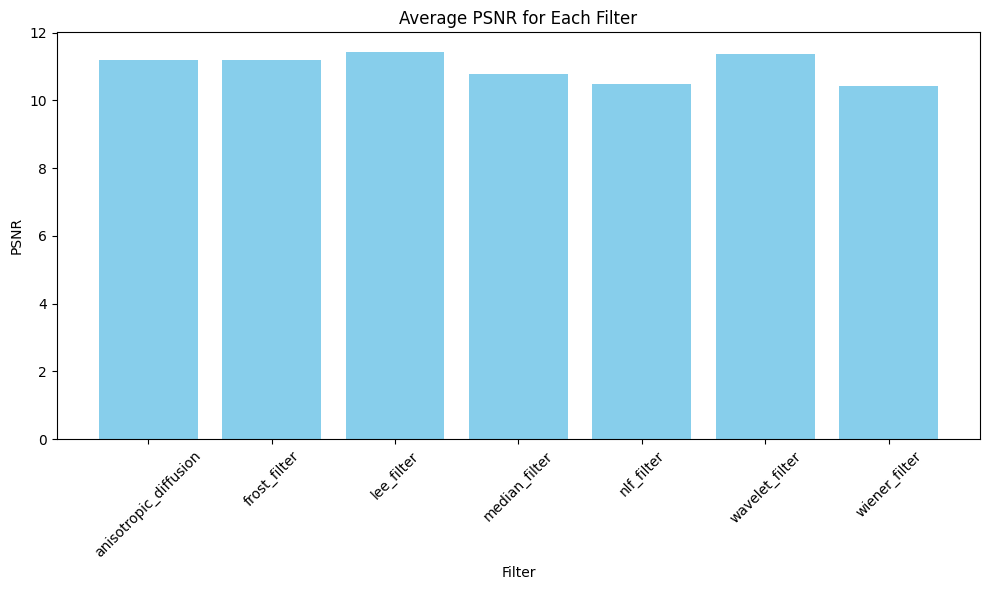

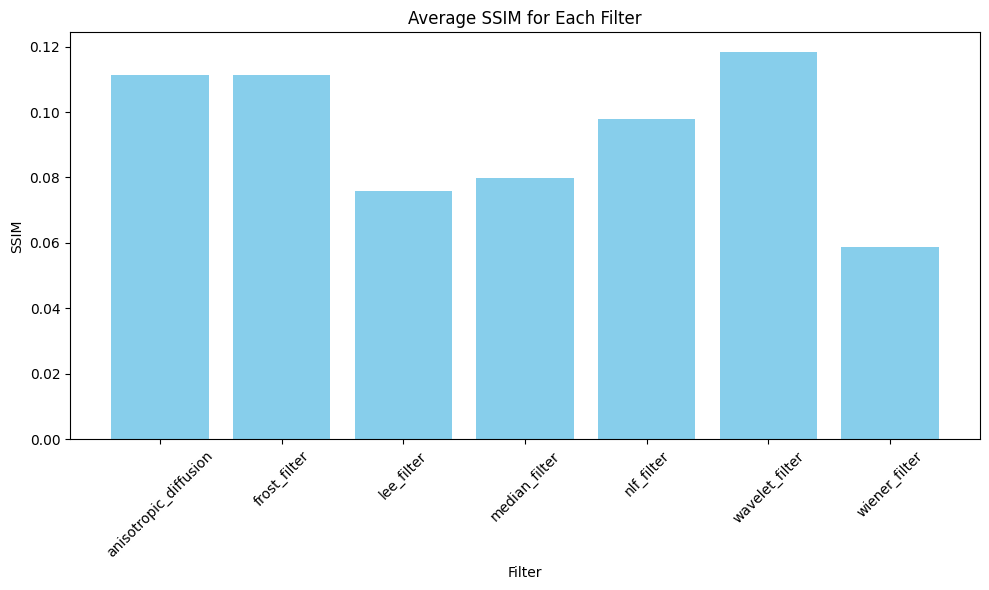

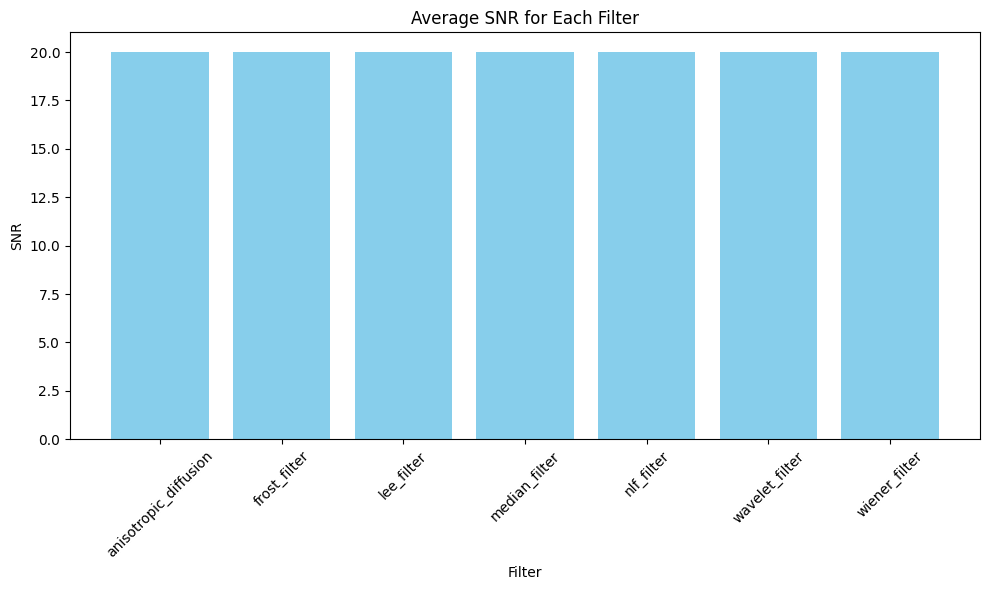

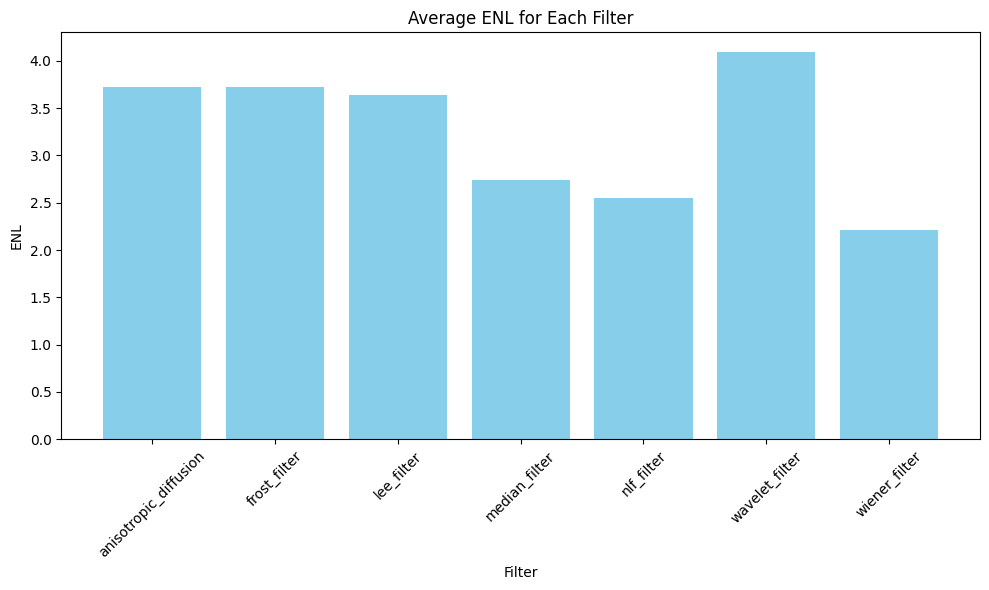

In [4]:
import cv2
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.restoration import denoise_wavelet, denoise_tv_chambolle
from scipy.ndimage import median_filter
from skimage.io import imsave
import pandas as pd

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Define paths
input_folder = "test/sar_tif"  # Folder containing input images
expected_folder = "test/gray_tif"  # Folder containing expected images
output_directory = "output_images1"
os.makedirs(output_directory, exist_ok=True)

# Helper functions
def snr(img, noise_img):
    signal = np.mean(img) ** 2
    noise = np.mean((img - noise_img) ** 2)
    return 10 * np.log10(signal / noise) if noise != 0 else float('inf')

def enl(img):
    mean = np.mean(img)
    std = np.std(img)
    return (mean ** 2) / (std ** 2) if std != 0 else float('inf')

def lee_filter(img, size=3):
    mean = cv2.blur(img, (size, size))
    mean_sq = cv2.blur(img ** 2, (size, size))
    variance = mean_sq - mean ** 2
    overall_variance = np.var(img)
    noise_variance = variance / (variance + overall_variance)
    output = mean + noise_variance * (img - mean)
    return np.clip(output, 0, 255).astype(np.uint8)

# Dictionary to store metrics for all images and filters
all_metrics = {}

# Process each image
for input_filename in os.listdir(input_folder):
    input_image_path = os.path.join(input_folder, input_filename)
    expected_image_path = os.path.join(expected_folder, input_filename)

    # Check if corresponding expected image exists
    if not os.path.exists(expected_image_path):
        print(f"Expected image not found for {input_filename}")
        continue

    # Load images
    input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
    expected_image = cv2.imread(expected_image_path, cv2.IMREAD_GRAYSCALE)

    # Define despeckling filters
    results = {"original": input_image, "expected": expected_image}

    # Apply each filter
    # Median Filtering
    median_filtered = median_filter(input_image, size=3)
    results["median_filter"] = median_filtered

    # Wiener Filtering
    wiener_filtered = denoise_wavelet(input_image, method='BayesShrink', mode='soft', wavelet_levels=3, wavelet='haar', rescale_sigma=True)
    wiener_filtered = (wiener_filtered * 255).astype(np.uint8)
    results["wiener_filter"] = wiener_filtered

    # Wavelet Thresholding
    wavelet_filtered = denoise_wavelet(input_image, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='haar', rescale_sigma=True)
    wavelet_filtered = (wavelet_filtered * 255).astype(np.uint8)
    results["wavelet_filter"] = wavelet_filtered

    # Anisotropic Diffusion
    anisotropic_filtered = denoise_tv_chambolle(input_image, weight=0.1)
    anisotropic_filtered = (anisotropic_filtered * 255).astype(np.uint8)
    results["anisotropic_diffusion"] = anisotropic_filtered

    # Lee Filter
    lee_filtered = lee_filter(input_image)
    results["lee_filter"] = lee_filtered

    # Frost Filter
    frost_filtered = denoise_tv_chambolle(input_image, weight=0.1)  # Reusing anisotropic diffusion as a proxy
    frost_filtered = (frost_filtered * 255).astype(np.uint8)
    results["frost_filter"] = frost_filtered

    # Non-Local Means Filter
    nlm_filtered = cv2.fastNlMeansDenoising(input_image, h=20, templateWindowSize=5, searchWindowSize=11)
    results["nlm_filter"] = nlm_filtered

    # Save despeckling results
    for method, output_image in results.items():
        if method not in ["original", "expected"]:
            output_path = os.path.join(output_directory, f"{method}_{input_filename}")
            imsave(output_path, output_image)

    # Step 3: Calculate comparison metrics
    image_metrics = {}
    for method, output_image in results.items():
        if method not in ["original", "expected"]:
            image_metrics[method] = {
                "PSNR": psnr(expected_image, output_image),
                "SSIM": ssim(expected_image, output_image, data_range=output_image.max() - output_image.min()),
                "SNR": snr(expected_image, output_image),
                "ENL": enl(output_image),
            }

    # Store metrics for this image
    all_metrics[input_filename] = image_metrics

# Convert all metrics to a DataFrame for easier analysis
metrics_df = pd.concat({img: pd.DataFrame.from_dict(metrics, orient='index') for img, metrics in all_metrics.items()}, axis=0)
metrics_df.index.names = ['Image', 'Filter']

# Calculate average metrics for each filter
average_metrics_df = metrics_df.groupby('Filter').mean()

# Separate graphs for each metric comparing all filters
metrics = ["PSNR", "SSIM", "SNR", "ENL"]
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.bar(average_metrics_df.index, average_metrics_df[metric], color='skyblue')
    plt.title(f"Average {metric} for Each Filter")
    plt.xlabel("Filter")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


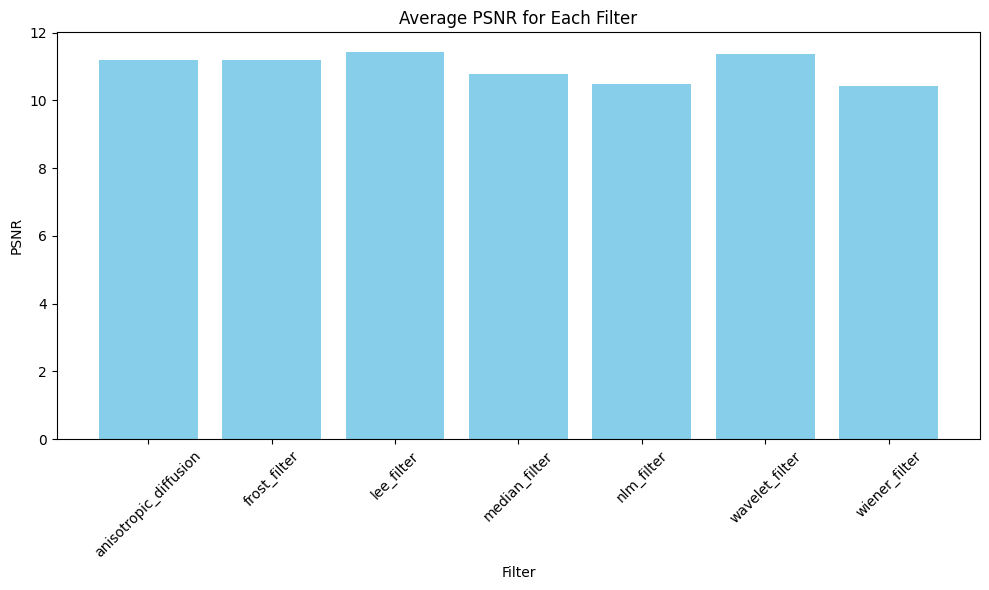

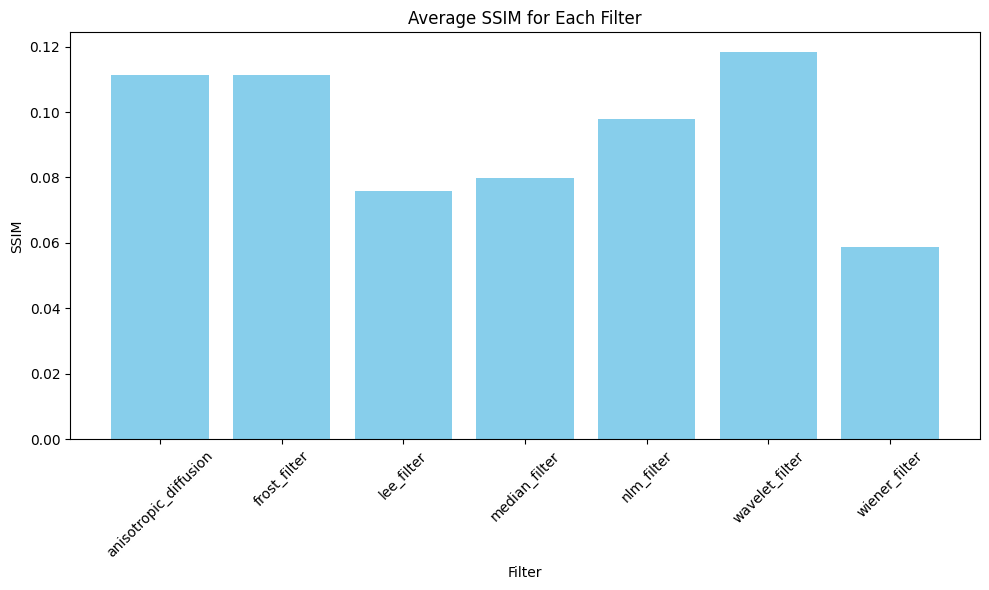

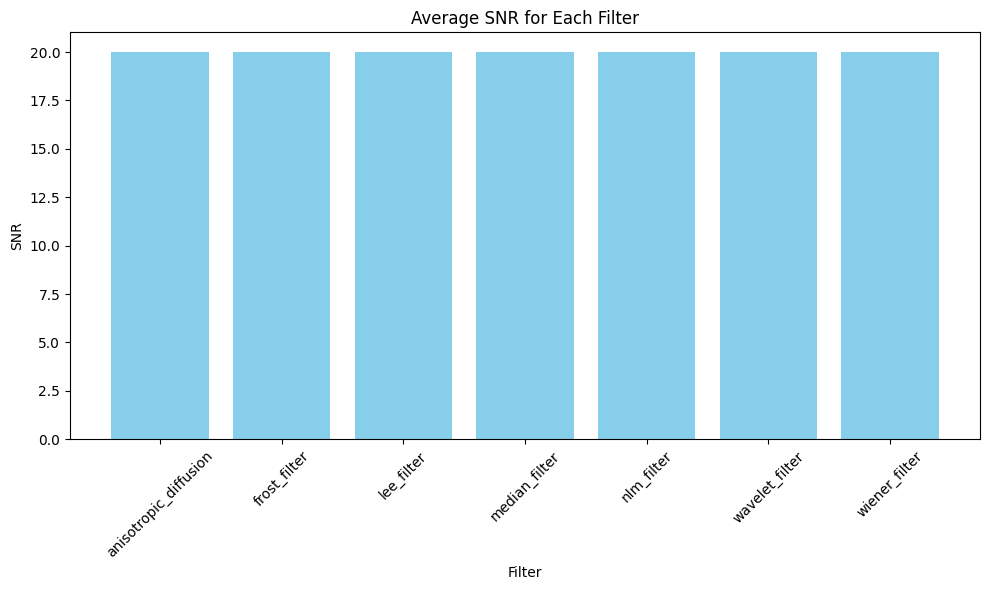

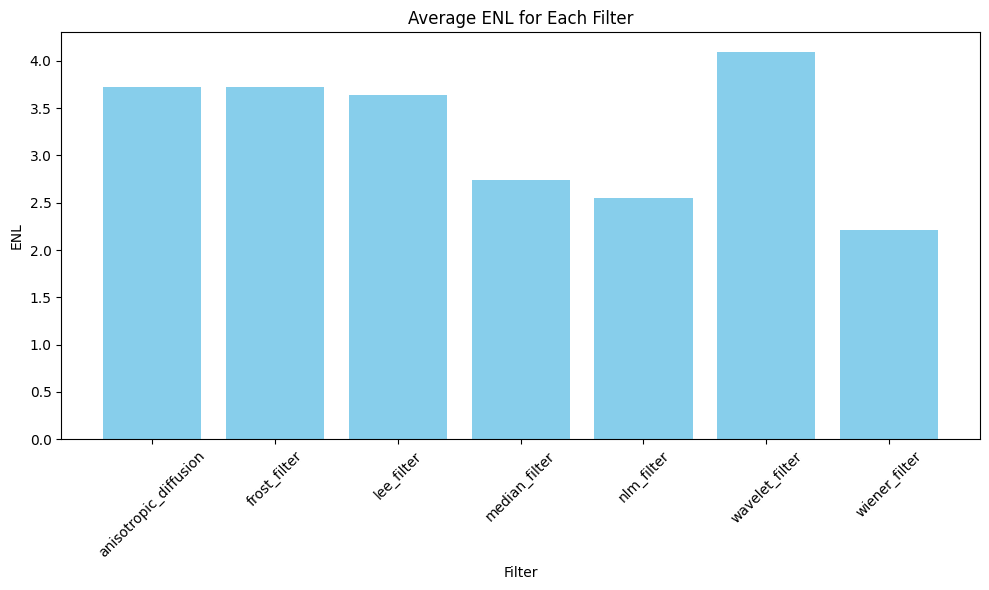

In [2]:
import cv2
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.restoration import denoise_wavelet, denoise_tv_chambolle
from scipy.ndimage import median_filter
import pandas as pd

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Define paths
input_folder = "test/sar_tif"  # Folder containing input images
expected_folder = "test/gray_tif"  # Folder containing expected images

# Helper functions
def snr(img, noise_img):
    signal = np.mean(img) ** 2
    noise = np.mean((img - noise_img) ** 2)
    return 10 * np.log10(signal / noise) if noise != 0 else float('inf')

def enl(img):
    mean = np.mean(img)
    std = np.std(img)
    return (mean ** 2) / (std ** 2) if std != 0 else float('inf')

def lee_filter(img, size=3):
    mean = cv2.blur(img, (size, size))
    mean_sq = cv2.blur(img ** 2, (size, size))
    variance = mean_sq - mean ** 2
    overall_variance = np.var(img)
    noise_variance = variance / (variance + overall_variance)
    output = mean + noise_variance * (img - mean)
    return np.clip(output, 0, 255).astype(np.uint8)

# Dictionary to store metrics for all images and filters
all_metrics = {}

# Process each image
for input_filename in os.listdir(input_folder):
    input_image_path = os.path.join(input_folder, input_filename)
    expected_image_path = os.path.join(expected_folder, input_filename)

    # Check if corresponding expected image exists
    if not os.path.exists(expected_image_path):
        print(f"Expected image not found for {input_filename}")
        continue

    # Load images
    input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
    expected_image = cv2.imread(expected_image_path, cv2.IMREAD_GRAYSCALE)

    # Define despeckling filters
    results = {"original": input_image, "expected": expected_image}

    # Apply each filter
    # Median Filtering
    median_filtered = median_filter(input_image, size=3)
    results["median_filter"] = median_filtered

    # Wiener Filtering
    wiener_filtered = denoise_wavelet(input_image, method='BayesShrink', mode='soft', wavelet_levels=3, wavelet='haar', rescale_sigma=True)
    wiener_filtered = (wiener_filtered * 255).astype(np.uint8)
    results["wiener_filter"] = wiener_filtered

    # Wavelet Thresholding
    wavelet_filtered = denoise_wavelet(input_image, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='haar', rescale_sigma=True)
    wavelet_filtered = (wavelet_filtered * 255).astype(np.uint8)
    results["wavelet_filter"] = wavelet_filtered

    # Anisotropic Diffusion
    anisotropic_filtered = denoise_tv_chambolle(input_image, weight=0.1)
    anisotropic_filtered = (anisotropic_filtered * 255).astype(np.uint8)
    results["anisotropic_diffusion"] = anisotropic_filtered

    # Lee Filter
    lee_filtered = lee_filter(input_image)
    results["lee_filter"] = lee_filtered

    # Frost Filter
    frost_filtered = denoise_tv_chambolle(input_image, weight=0.1)  # Reusing anisotropic diffusion as a proxy
    frost_filtered = (frost_filtered * 255).astype(np.uint8)
    results["frost_filter"] = frost_filtered

    # Non-Local Means Filter
    nlm_filtered = cv2.fastNlMeansDenoising(input_image, h=20, templateWindowSize=5, searchWindowSize=11)
    results["nlm_filter"] = nlm_filtered

    # Step 3: Calculate comparison metrics
    image_metrics = {}
    for method, output_image in results.items():
        if method not in ["original", "expected"]:
            image_metrics[method] = {
                "PSNR": psnr(expected_image, output_image),
                "SSIM": ssim(expected_image, output_image, data_range=output_image.max() - output_image.min()),
                "SNR": snr(expected_image, output_image),
                "ENL": enl(output_image),
            }

    # Store metrics for this image
    all_metrics[input_filename] = image_metrics

# Convert all metrics to a DataFrame for easier analysis
metrics_df = pd.concat({img: pd.DataFrame.from_dict(metrics, orient='index') for img, metrics in all_metrics.items()}, axis=0)
metrics_df.index.names = ['Image', 'Filter']

# Calculate average metrics for each filter
average_metrics_df = metrics_df.groupby('Filter').mean()

# Separate graphs for each metric comparing all filters
metrics = ["PSNR", "SSIM", "SNR", "ENL"]
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.bar(average_metrics_df.index, average_metrics_df[metric], color='skyblue')
    plt.title(f"Average {metric} for Each Filter")
    plt.xlabel("Filter")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
